In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sea
import os
from tqdm.notebook import tqdm
import sklearn
import scipy
from PIL import Image

plt.style.use('seaborn')

np.__version__

/tmp/ipykernel_73327/2309886784.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


'1.24.4'

## 1.1

In [2]:
cfw_dict = {
    'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7
}

opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

In [30]:
# load the image
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# display images with row, col
def display_images(imgs,classes,row=1,col=2,w=32,h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

# load the image data
def load_data(dir_path):
    image_list = []
    y_list = []
    label_dict = cfw_dict
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print("Dataset shape:",image_list.shape)
    print("Label shape:",y_list.shape)

    return image_list, y_list

In [31]:
PATH = 'IIIT-CFW/'
X, y = load_data(PATH)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)


Exception ignored in: <function tqdm.__del__ at 0x7f46b9d81f70>
Traceback (most recent call last):
  File "/home/faizal/Documents/SMAI/env/lib/python3.8/site-packages/tqdm/std.py", line 1149, in __del__
    self.close()
  File "/home/faizal/Documents/SMAI/env/lib/python3.8/site-packages/tqdm/notebook.py", line 281, in close
    self.disp(bar_style='success', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


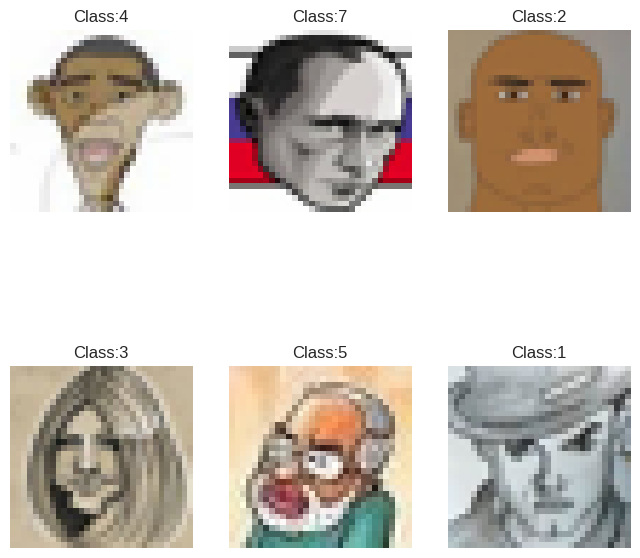

In [32]:
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

ind = np.random.randint(0,y.shape[0],6)
display_images(X[ind,...],y[ind], row = 2,col = 3)

In [7]:

'''
    A : n x d
    (A.T * A)x = kx
    A * A.T * Ax = k Ax
    (A * A.T)u = ku
    where u = Ax
''' 

# PCA class to perform pca.

class PCA:
    def __init__(self, k):
        self.k = k
        
    # perform pca
    def fit(self, X):
        X_new = X.reshape(X.shape[0], -1) # 672, 64*64
        self.mu = np.mean(X_new, axis=0)
        
        X_new = (X_new - self.mu.reshape(1, -1))
        
        covariance = np.dot(X_new.T, X_new)/(X_new.shape[0] - 1)
        
        eigvalues, eigvectors = np.linalg.eig(covariance)
        eigvalues, eigvectors = np.real(eigvalues), np.real(eigvectors)
        
        sorted_eigvalues_indices = np.flip(np.argsort(eigvalues))
        self.sorted_eigvalues = eigvalues[sorted_eigvalues_indices]
        self.sorted_eigvectors = eigvectors[sorted_eigvalues_indices]
        
        return np.dot(X_new, self.sorted_eigvectors[:, :self.k])
    
    # reconstruct the pca data to original data
    def reconstruct(self, X):
        return np.dot(X, self.sorted_eigvectors[:, :self.k].T) + self.mu.reshape(1, -1)


k = 16 * 16
pca = PCA(k = k)

X_pca = pca.fit(X)

X_pca.shape

(672, 256)

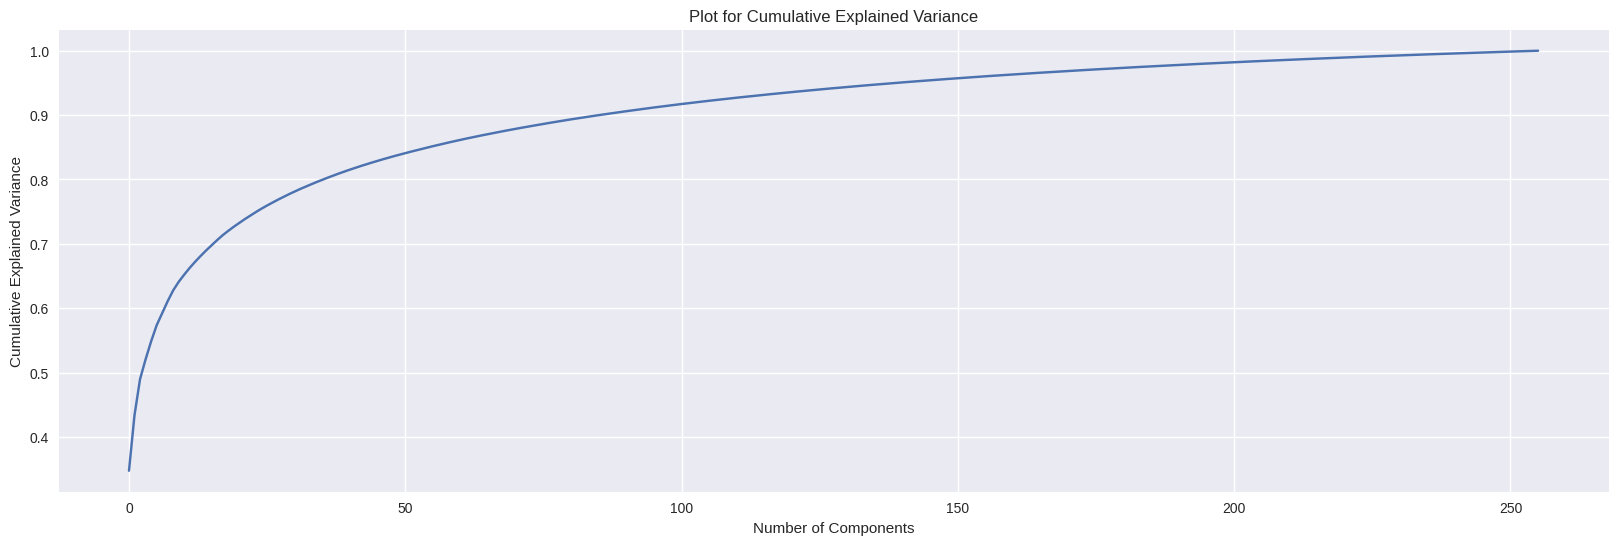

In [12]:
plt.figure(figsize=(20, 6))
plt.plot(np.cumsum(pca.sorted_eigvalues[:k])/np.sum(pca.sorted_eigvalues[:k]))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Plot for Cumulative Explained Variance')
plt.show()


In [35]:
from sklearn.linear_model import LogisticRegression

def pca_model_analysis(X, y, n_components):
    X_pca = X @ pca.sorted_eigvectors[:, :n_components]
    model = LogisticRegression(max_iter=100)
    model.fit(X_pca, y)
    pred = model.score(X_pca, y)
    return pred

accuracies_vgg, accuracies_resnet = [], []

data_vgg = np.load('./IIIT-CFW/VGG19_features.npy', allow_pickle=True)
data_resnet = np.load('./IIIT-CFW/resnet50_features.npy', allow_pickle=True)


pca = PCA(k = k)
pca.fit(data_vgg)

for i in tqdm(range(1, 256)):
    acc = pca_model_analysis(data_vgg, y, i)
    accuracies_vgg.append(acc)

pca = PCA(k = k)
pca.fit(data_resnet)
for i in tqdm(range(1, 256)):
    acc = pca_model_analysis(data_resnet, y, i)
    accuracies_resnet.append(acc)



  0%|          | 0/255 [00:00<?, ?it/s]

/home/faizal/Documents/SMAI/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/faizal/Documents/SMAI/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

  0%|          | 0/255 [00:00<?, ?it/s]

/home/faizal/Documents/SMAI/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/faizal/Documents/SMAI/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

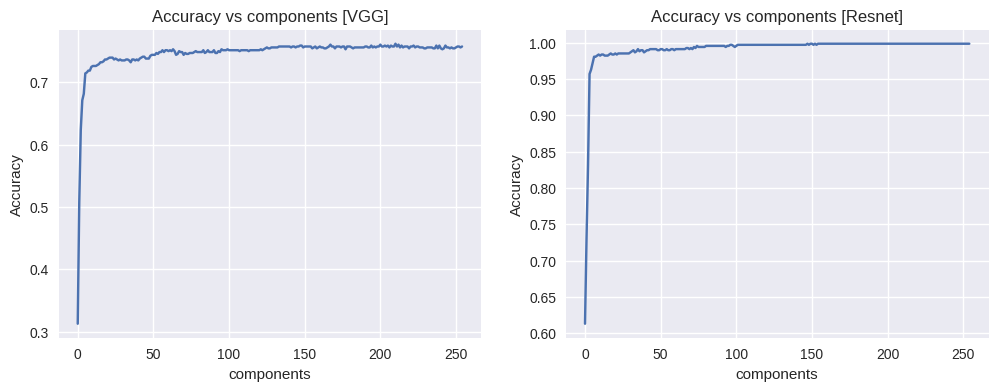

In [37]:

plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.title("Accuracy vs components [VGG]")
plt.xlabel('components')
plt.ylabel('Accuracy')
plt.plot(accuracies_vgg)

plt.subplot(1,2,2)
plt.title("Accuracy vs components [Resnet]")
plt.xlabel('components')
plt.ylabel('Accuracy')
plt.plot(accuracies_resnet)



In [77]:
from knn import reshape_data, KNNModel, euclidean, print_output
from sklearn.model_selection import train_test_split

pca = PCA(k=200)

def load_data(data, do_pca=False):
    resnet, vit, y = reshape_data(data[:, 1]), reshape_data(data[:, 2]), data[:, 3]
    
    if do_pca:
        resnet, vit = np.expand_dims(pca.fit(resnet), -1), np.expand_dims(pca.fit(vit), -1)
    
    resnet_train, resnet_val, y_resnet_train, y_resnet_val = train_test_split(
        resnet, y, test_size=0.2)
    
    vit_train, vit_val, y_vit_train, y_vit_val = train_test_split(
        vit, y, test_size=0.2)

    return (
        {
            'resnet': {'X': resnet_train, 'y': y_resnet_train},
            'vit': {'X': vit_train, 'y': y_vit_train}
        },

        {
            'resnet': {'X': resnet_val, 'y': y_resnet_val},
            'vit': {'X': vit_val, 'y': y_vit_val}
        }
    )


def do_pca_on_pic(path, do_pca = False):
    data = np.load(path, allow_pickle=True)

    train_data, val_data = load_data(data, do_pca)

    model1 = KNNModel(train_data=train_data,
                      encoder_type='vit',
                      k=1,
                      distance_metric=euclidean,
                      scaler='standardization',
                      metric_average='micro',
                      optimized=True)

    model2 = KNNModel(train_data=train_data,
                      encoder_type='resnet',
                      k=1,
                      distance_metric=euclidean,
                      metric_average='micro',
                      scaler='standardization',
                      optimized=True)

    output1 = model1.get_scores(*val_data['vit'].values())
    output2 = model2.get_scores(*val_data['resnet'].values())

    print_output(output1, 'vit')
    print_output(output2, 'resnet')

In [78]:
print("Without pca:")
do_pca_on_pic('./Data/data.npy', do_pca=False)


print("\nWith pca:")
do_pca_on_pic('./Data/data.npy', do_pca=True)


Without pca:
Encoder: vit
acc : 0.253
precision : 0.253
recall : 0.253
f1 : 0.253
time : 0.163
Encoder: resnet
acc : 0.197
precision : 0.197
recall : 0.197
f1 : 0.197
time : 0.436

With pca:
Encoder: vit
acc : 0.227
precision : 0.227
recall : 0.227
f1 : 0.227
time : 0.112
Encoder: resnet
acc : 0.170
precision : 0.170
recall : 0.170
f1 : 0.170
time : 0.082


From the above, we can observe that the KNN model gives comparable results even with ~ 200 features. Hence, through PCA, we can reduce the dimensionality of the data and at the same time achieve similiar performance compared to original data

## 1.2

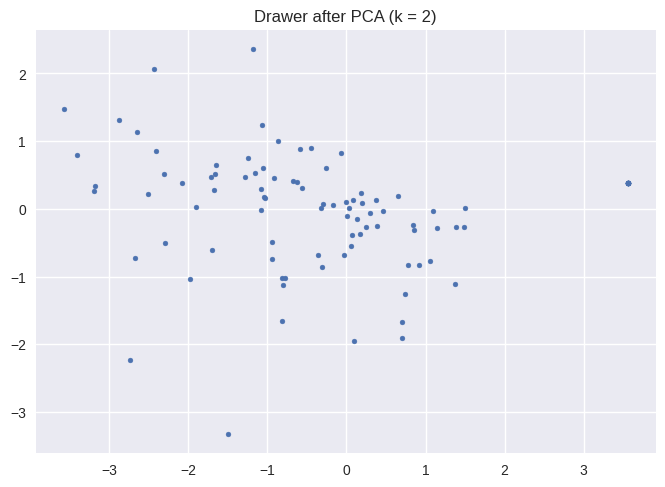

In [28]:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df_drawer = pd.read_csv('./Data/drawer_attributes.csv').drop(columns=['d_drawer'], axis=0)

drawer = scaler.fit_transform(df_drawer.values)

pca = PCA(k = 2)
drawer_pca = pca.fit(drawer)

plt.scatter(x = drawer_pca[:, 0], y = drawer_pca[:, 1], marker = '.')
plt.title('Drawer after PCA (k = 2)')
plt.show()

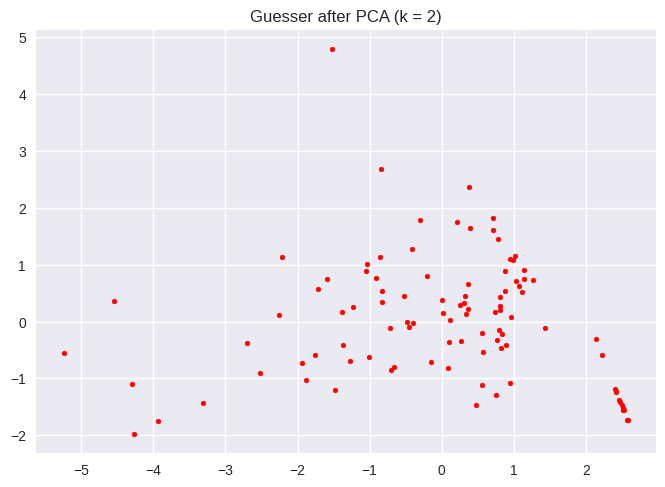

In [29]:
df_guesser = pd.read_csv('./Data/guesser_attributes.csv')

guesser = scaler.fit_transform(df_guesser)
pca = PCA(k = 2)
guesser_pca = pca.fit(guesser)

plt.scatter(x = guesser_pca[:, 0], y = guesser_pca[:, 1], marker = '.', color = 'red')
plt.title('Guesser after PCA (k = 2)')
plt.show()

1. First Principal Component (PC1): The first principal component captures the direction of maximum variance in the data. It represents the most dominant pattern or feature that explains the most significant variation in the data.

2. Second Principal Component (PC2): The second principal component is orthogonal (uncorrelated) to the first principal component and represents the direction of the second-highest variance in the data. PC2 captures additional variation in the data that is not explained by PC1